<a href="https://colab.research.google.com/github/FajarWahyuSuryaputra/Pembelajaran_Mesin/blob/main/recommenderML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install implicit

In [19]:
import pandas as pd
import numpy as np
import time
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split

##Tugas 1

In [20]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

Jumlah user: 500
Jumlah film: 9108
Jumlah rating: 81021


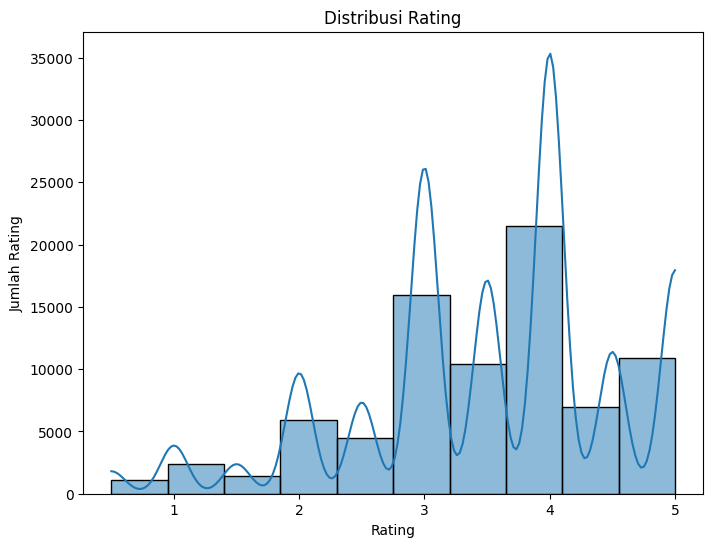

In [29]:
df = pd.merge(ratings, movies, on='movieId')

print(f"Jumlah user: {df['userId'].nunique()}")
print(f"Jumlah film: {df['movieId'].nunique()}")
print(f"Jumlah rating: {len(df)}")

plt.figure(figsize=(8, 6))
sns.histplot(df['rating'], bins=10, kde=True)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah Rating')
plt.show()

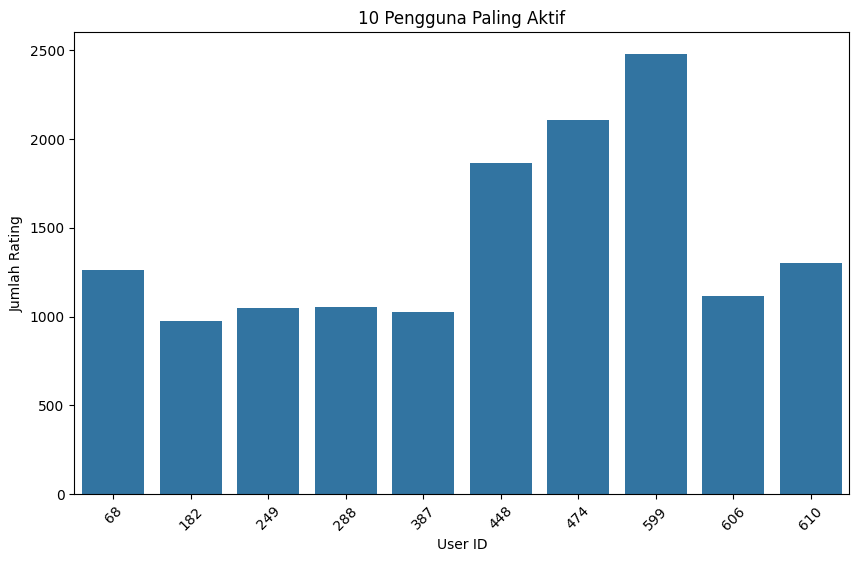

In [30]:
active_users = df['userId'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=active_users.index, y=active_users.values)
plt.title('10 Pengguna Paling Aktif')
plt.xlabel('User ID')
plt.ylabel('Jumlah Rating')
plt.xticks(rotation=45)
plt.show()

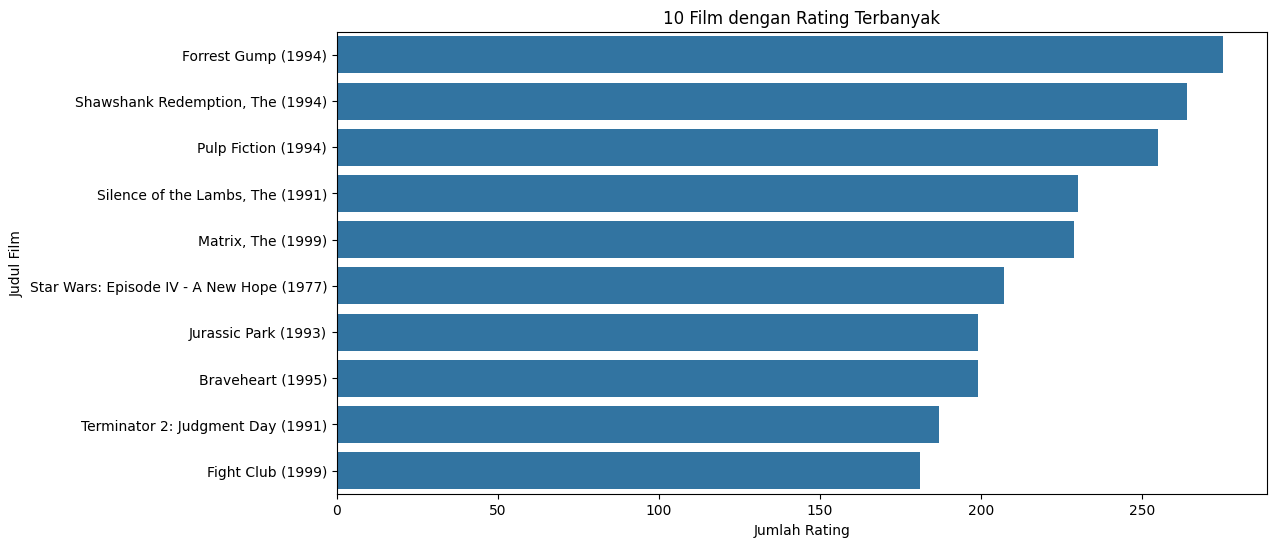

In [31]:
popular_movies = df['title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=popular_movies.values, y=popular_movies.index)
plt.title('10 Film dengan Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
plt.show()

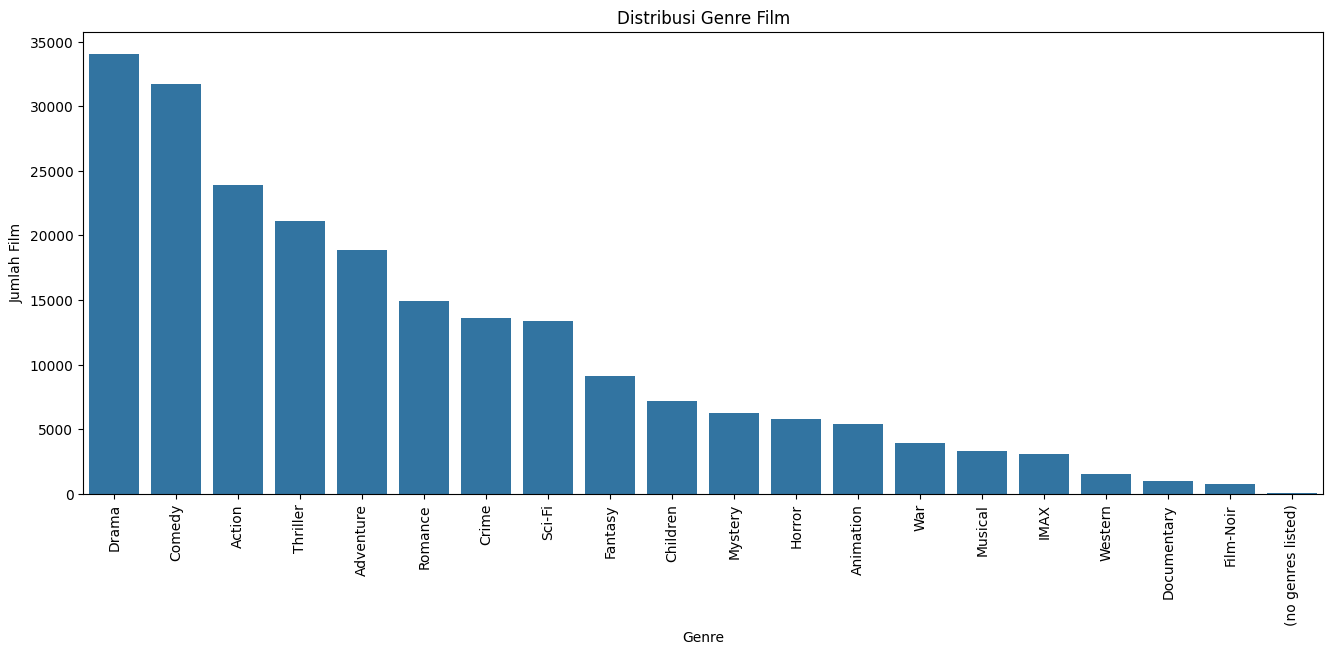

In [34]:
all_genres = []
for genres in df['genres']:
  all_genres.extend(genres.split('|'))
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(16, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Distribusi Genre Film')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=90)
plt.show()

##Tugas 2

In [36]:
df = pd.read_csv('steam-200k.csv', header=None)
df.columns = ['user_id', 'game', 'behavior', 'hours', 'timestamp']
df = df[df['behavior'] == 'play'].copy()

df.reset_index(drop=True, inplace=True)
df['simulated_time'] = len(df) - df.index

most_popular = df.groupby('game')['hours'].sum().sort_values(ascending=False).reset_index()
most_popular.columns = ['game', 'total_hours']

In [37]:
def linear_decay(pos):
    return pos / pos.max()

def exponential_decay(pos, alpha=0.0001):
    return np.exp(-alpha * (pos.max() - pos))

def custom_decay(pos):
    return 1 / (1 + np.log1p(pos.max() - pos))

df['linear_weight'] = linear_decay(df['simulated_time'])
df['exp_weight'] = exponential_decay(df['simulated_time'])
df['custom_weight'] = custom_decay(df['simulated_time'])

In [38]:
def weighted_hours(df, weight_col):
    return df.assign(weighted=df['hours'] * df[weight_col]) \
             .groupby('game')['weighted'].sum() \
             .sort_values(ascending=False).reset_index()

trending_linear = weighted_hours(df, 'linear_weight')
trending_exp = weighted_hours(df, 'exp_weight')
trending_custom = weighted_hours(df, 'custom_weight')

In [39]:
top_n = 10

rank_df = most_popular.head(top_n)[['game']].copy()
rank_df['Most_Popular_Rank'] = range(1, top_n+1)

trending_linear = trending_linear[trending_linear['game'].isin(rank_df['game'])]
trending_linear['Linear_Rank'] = trending_linear['weighted'].rank(ascending=False, method='min')

trending_exp = trending_exp[trending_exp['game'].isin(rank_df['game'])]
trending_exp['Exp_Rank'] = trending_exp['weighted'].rank(ascending=False, method='min')

trending_custom = trending_custom[trending_custom['game'].isin(rank_df['game'])]
trending_custom['Custom_Rank'] = trending_custom['weighted'].rank(ascending=False, method='min')

rank_df = rank_df.merge(trending_linear[['game', 'Linear_Rank']], on='game', how='left')
rank_df = rank_df.merge(trending_exp[['game', 'Exp_Rank']], on='game', how='left')
rank_df = rank_df.merge(trending_custom[['game', 'Custom_Rank']], on='game', how='left')

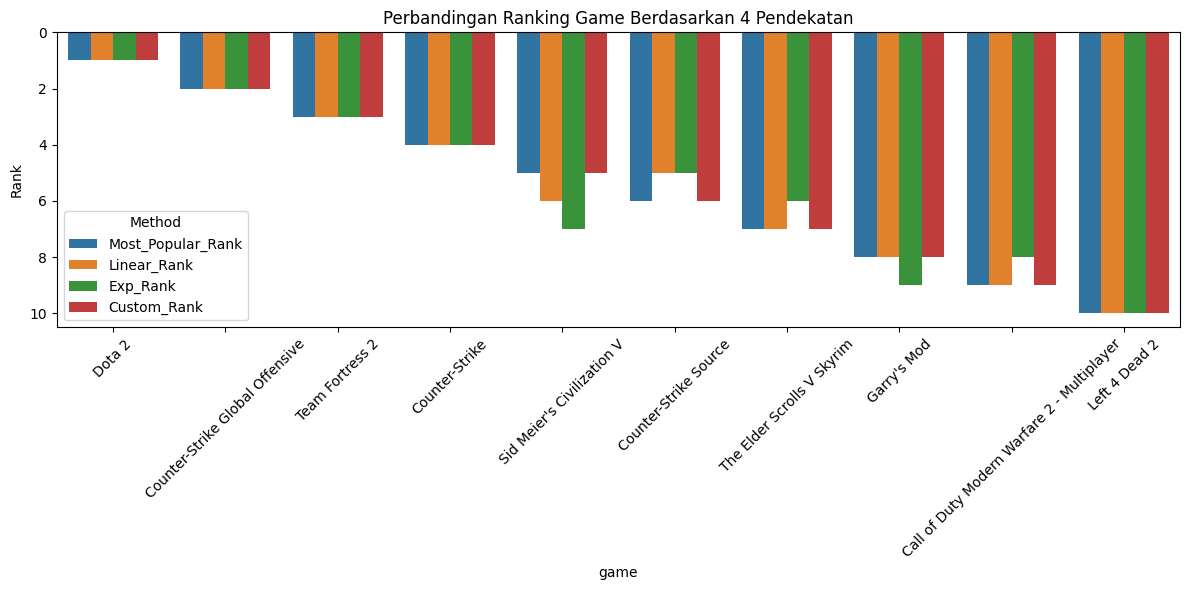

In [40]:
rank_melt = pd.melt(rank_df, id_vars='game',
                    value_vars=['Most_Popular_Rank', 'Linear_Rank', 'Exp_Rank', 'Custom_Rank'],
                    var_name='Method', value_name='Rank')

plt.figure(figsize=(12, 6))
sns.barplot(data=rank_melt, x='game', y='Rank', hue='Method')
plt.title('Perbandingan Ranking Game Berdasarkan 4 Pendekatan')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##Tugas 3

In [42]:
books = pd.read_csv("books.csv")
tags = pd.read_csv("tags(goodbooks).csv")
book_tags = pd.read_csv("book_tags.csv")

book_tags_merged = pd.merge(book_tags, tags, on='tag_id')
top_tags = (
    book_tags_merged
    .sort_values(['goodreads_book_id', 'count'], ascending=False)
    .groupby('goodreads_book_id')['tag_name']
    .apply(lambda x: ' '.join(x.head(10)))
    .reset_index()
)

books = pd.merge(books, top_tags, on='goodreads_book_id', how='left')

In [43]:
tfidf_authors = TfidfVectorizer(stop_words='english')
tfidf_matrix_authors = tfidf_authors.fit_transform(books['authors'].fillna(''))
cos_sim_authors = cosine_similarity(tfidf_matrix_authors)

tfidf_tags = TfidfVectorizer(stop_words='english')
tfidf_matrix_tags = tfidf_tags.fit_transform(books['tag_name'].fillna(''))
cos_sim_tags = cosine_similarity(tfidf_matrix_tags)

books['combined_features'] = books['authors'].fillna('') + " " + books['tag_name'].fillna('')
tfidf_combined = TfidfVectorizer(stop_words='english')
tfidf_matrix_combined = tfidf_combined.fit_transform(books['combined_features'])
cos_sim_combined = cosine_similarity(tfidf_matrix_combined)

print("TF-IDF Shapes:")
print("- Authors:", tfidf_matrix_authors.shape)
print("- Tags:", tfidf_matrix_tags.shape)
print("- Combined:", tfidf_matrix_combined.shape)

indices = pd.Series(books.index, index=books['title'].str.lower()).drop_duplicates()

TF-IDF Shapes:
- Authors: (10000, 6175)
- Tags: (10000, 1953)
- Combined: (10000, 7398)


In [44]:
def recommend(title, cosine_sim_matrix, n=10):
    title = title.lower()
    if title not in indices:
        return f"Judul '{title}' tidak ditemukan."

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_books = [i for i, _ in sim_scores[1:n+1]]
    return books[['title', 'authors']].iloc[top_books]

def recommend_from_favorites(favorite_titles, cosine_sim_matrix, n=10):
    idx_list = [indices.get(title.lower()) for title in favorite_titles if title.lower() in indices]
    if not idx_list:
        return "Tidak ada judul valid ditemukan dalam daftar favorit."

    sim_total = sum([cosine_sim_matrix[idx] for idx in idx_list])
    avg_sim = sim_total / len(idx_list)
    sim_scores = list(enumerate(avg_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_books = [i for i, _ in sim_scores if i not in idx_list][:n]
    return books[['title', 'authors']].iloc[top_books]

In [45]:
query = "The Hunger Games (The Hunger Games, #1)"

print("\nRekomendasi berdasarkan PENULIS:")
print(recommend(query, cos_sim_authors))


Rekomendasi berdasarkan PENULIS:
                                                  title           authors
16                 Catching Fire (The Hunger Games, #2)   Suzanne Collins
19                    Mockingjay (The Hunger Games, #3)   Suzanne Collins
506   The Hunger Games Trilogy Boxset (The Hunger Ga...   Suzanne Collins
1530   Gregor the Overlander (Underland Chronicles, #1)   Suzanne Collins
2934  Gregor and the Code of Claw (Underland Chronic...   Suzanne Collins
3178  Gregor and the Curse of the Warmbloods (Underl...   Suzanne Collins
3711  Gregor and the Prophecy of Bane (Underland Chr...   Suzanne Collins
4719  Gregor and the Marks of Secret (Underland Chro...   Suzanne Collins
931   Good to Great: Why Some Companies Make the Lea...  James C. Collins
4023                      The Program (The Program, #1)     Suzanne Young


In [46]:
print("\nRekomendasi berdasarkan TAG:")
print(recommend(query, cos_sim_tags))


Rekomendasi berdasarkan TAG:
                                            title                   authors
485         The City of Ember (Book of Ember, #1)             Jeanne DuPrau
19              Mockingjay (The Hunger Games, #3)           Suzanne Collins
3317                Birthmarked (Birthmarked, #1)         Caragh M. O'Brien
1289                    Messenger (The Giver, #3)                Lois Lowry
3083     The People of Sparks (Book of Ember, #2)             Jeanne DuPrau
5889   The Prophet of Yonwood (Book of Ember, #3)             Jeanne DuPrau
6900  The Diamond of Darkhold (Book of Ember, #4)             Jeanne DuPrau
104                     Allegiant (Divergent, #3)             Veronica Roth
1058       Among the Hidden (Shadow Children, #1)  Margaret Peterson Haddix
5540    Among the Impostors (Shadow Children, #2)  Margaret Peterson Haddix


In [47]:
print("\nRekomendasi berdasarkan KOMBINASI:")
print(recommend(query, cos_sim_combined))


Rekomendasi berdasarkan KOMBINASI:
                                                  title          authors
19                    Mockingjay (The Hunger Games, #3)  Suzanne Collins
506   The Hunger Games Trilogy Boxset (The Hunger Ga...  Suzanne Collins
3178  Gregor and the Curse of the Warmbloods (Underl...  Suzanne Collins
4023                      The Program (The Program, #1)    Suzanne Young
16                 Catching Fire (The Hunger Games, #2)  Suzanne Collins
4719  Gregor and the Marks of Secret (Underland Chro...  Suzanne Collins
2934  Gregor and the Code of Claw (Underland Chronic...  Suzanne Collins
3711  Gregor and the Prophecy of Bane (Underland Chr...  Suzanne Collins
8525                 The Bar Code Tattoo (Bar Code, #1)     Suzanne Weyn
1530   Gregor the Overlander (Underland Chronicles, #1)  Suzanne Collins


In [48]:
favorites = ["The Hunger Games (The Hunger Games, #1)", "Divergent (Divergent, #1)"]
print("\nRekomendasi berdasarkan beberapa favorit:")
print(recommend_from_favorites(favorites, cos_sim_combined))


Rekomendasi berdasarkan beberapa favorit:
                                                  title          authors
19                    Mockingjay (The Hunger Games, #3)  Suzanne Collins
104                           Allegiant (Divergent, #3)    Veronica Roth
68                            Insurgent (Divergent, #2)    Veronica Roth
506   The Hunger Games Trilogy Boxset (The Hunger Ga...  Suzanne Collins
6213  The Divergent Series 2-Book Collection (Diverg...    Veronica Roth
7671                      The Traitor (Divergent, #0.4)    Veronica Roth
4023                      The Program (The Program, #1)    Suzanne Young
3284  The World of Divergent: The Path to Allegiant ...    Veronica Roth
2879  Divergent Series Complete Box Set (Divergent, ...    Veronica Roth
2456                     The Transfer (Divergent, #0.1)    Veronica Roth


##Tugas 5

In [50]:
df = pd.read_csv("events.csv")

df = df[df['event'] == 'view']
sample_users = df['visitorid'].drop_duplicates().sample(n=500, random_state=42)
df = df[df['visitorid'].isin(sample_users)]

user_map = {u: i for i, u in enumerate(df['visitorid'].unique())}
item_map = {i: j for j, i in enumerate(df['itemid'].unique())}
df['user_idx'] = df['visitorid'].map(user_map)
df['item_idx'] = df['itemid'].map(item_map)

In [51]:
interactions = df.groupby(['user_idx', 'item_idx']).size().reset_index(name='interaction')
n_users = df['user_idx'].nunique()
n_items = df['item_idx'].nunique()

train_df, test_df = train_test_split(interactions, test_size=0.2, random_state=42)

def build_matrix(df, n_users, n_items):
    return csr_matrix((df['interaction'], (df['user_idx'], df['item_idx'])), shape=(n_users, n_items))

train_matrix = build_matrix(train_df, n_users, n_items)
test_matrix = build_matrix(test_df, n_users, n_items)

In [52]:
als_model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=10)
als_model.fit(train_matrix.T)

def train_svd(train_matrix, k=20):
    R = train_matrix.toarray()
    user_ratings_mean = np.mean(R, axis=1)
    R_demeaned = R - user_ratings_mean.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k=k)
    sigma = np.diag(sigma)
    predictions = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    return predictions

svd_predictions = train_svd(train_matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

In [53]:
def precision_recall_at_k(model, train_matrix, test_matrix, k=10):
    precisions = []
    recalls = []

    for user in range(train_matrix.shape[0]):
        user_items = train_matrix[user]

        try:
            recommended = model.recommend(userid=user, user_items=user_items, N=k, filter_already_liked_items=True)
        except:
            continue

        if isinstance(recommended[0], (list, tuple, np.ndarray)):
            recommended_items = [int(item_id) for item_id, *_ in recommended]
        else:
            recommended_items = [int(item_id) for item_id in recommended]

        true_items = [int(item) for item in test_matrix[user].indices]

        if len(true_items) == 0:
            continue

        hit_set = set(recommended_items) & set(true_items)
        precisions.append(len(hit_set) / k)
        recalls.append(len(hit_set) / len(true_items))

    return np.mean(precisions), np.mean(recalls)

def precision_recall_at_k_svd(recommend_func, test_matrix, k=10):
    precisions = []
    recalls = []

    for user in range(test_matrix.shape[0]):
        recommended_items = recommend_func(user)
        true_items = test_matrix[user].indices
        if len(true_items) == 0:
            continue
        hit_set = set(recommended_items[:k]) & set(true_items)
        precision = len(hit_set) / k
        recall = len(hit_set) / len(true_items)
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

In [54]:
def als_recommend(user, train_items, k=10):
    recs = als_model.recommend(user, train_matrix, N=k, filter_items=list(train_items), recalculate_user=True)
    return [item for item, score in recs]

def svd_recommend(user, train_items, k=10):
    scores = svd_predictions[user]
    scores[list(train_items)] = -np.inf
    return list(np.argsort(-scores)[:k])

In [55]:
prec_als, rec_als = precision_recall_at_k(als_model, train_matrix, test_matrix, k=10)
prec_svd, rec_svd = precision_recall_at_k(svd_recommend, train_matrix, test_matrix, k=10)

print("=== EVALUASI ALS ===")
print(f"Precision@10: {prec_als:.4f}")
print(f"Recall@10   : {rec_als:.4f}\n")

print("=== EVALUASI SVD ===")
print(f"Precision@10: {prec_svd:.4f}")
print(f"Recall@10   : {rec_svd:.4f}")

=== EVALUASI ALS ===
Precision@10: 0.0000
Recall@10   : 0.0000

=== EVALUASI SVD ===
Precision@10: nan
Recall@10   : nan


##Tugas 6

In [57]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

sample_users = ratings['userId'].drop_duplicates().sample(n=500, random_state=42)
ratings = ratings[ratings['userId'].isin(sample_users)]

In [58]:
movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer(token_pattern='[a-zA-Z0-9-]+')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = cosine_similarity(tfidf_matrix)

movie_indices = pd.Series(movies.index, index=movies['movieId'])

def content_based_recommendations(movie_id, top_n=10):
    idx = movie_indices[movie_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices_rec = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices_rec][['movieId', 'title']]

In [59]:
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_movie_matrix_filled = user_movie_matrix.fillna(0)
user_sim = cosine_similarity(user_movie_matrix_filled)
user_sim_df = pd.DataFrame(user_sim, index=user_movie_matrix.index, columns=user_movie_matrix.index)

def user_based_recommendations(user_id, top_n=10):
    similar_users = user_sim_df[user_id].sort_values(ascending=False)[1:11]
    weighted_ratings = user_movie_matrix.loc[similar_users.index].T.dot(similar_users)
    recs = weighted_ratings / similar_users.sum()
    recs = recs.sort_values(ascending=False)
    return recs.head(top_n).index.tolist()

In [60]:
U, sigma, Vt = np.linalg.svd(user_movie_matrix_filled.values, full_matrices=False)
sigma_diag_matrix = np.diag(sigma)
k = 50
pred_matrix = np.dot(np.dot(U[:, :k], sigma_diag_matrix[:k, :k]), Vt[:k, :])

mask = ~np.isnan(user_movie_matrix.values)
rmse = np.sqrt(mean_squared_error(user_movie_matrix.values[mask], pred_matrix[mask]))

In [61]:
def weighted_hybrid(user_id, movie_id, alpha=0.5):
    try:
        user_idx = user_movie_matrix.index.get_loc(user_id)
        movie_idx = user_movie_matrix.columns.get_loc(movie_id)
        svd_score = pred_matrix[user_idx, movie_idx]
    except:
        svd_score = 0

    try:
        idx = movie_indices[movie_id]
        sim_scores = cosine_sim[idx]
        mean_sim = np.mean(sim_scores)
    except:
        mean_sim = 0

    return alpha * svd_score + (1 - alpha) * mean_sim

movies['avg_svd_score'] = [np.mean(pred_matrix[:, i]) if i < pred_matrix.shape[1] else 0 for i in range(len(movies))]

In [62]:
def contextual_recommend(user_id, time):
    hour = datetime.fromtimestamp(time).hour
    if hour < 12:
        return content_based_recommendations(1)
    else:
        return user_based_recommendations(user_id)

In [63]:
from sklearn.metrics import precision_score, recall_score

def precision_recall_at_k(true_ratings, pred_ratings, k=10):
    precision_list = []
    recall_list = []
    for user in true_ratings.index:
        true_top_k = true_ratings.loc[user].sort_values(ascending=False).head(k).index
        pred_top_k = pred_ratings.loc[user].sort_values(ascending=False).head(k).index
        precision = len(set(true_top_k) & set(pred_top_k)) / k
        recall = len(set(true_top_k) & set(pred_top_k)) / len(true_top_k)
        precision_list.append(precision)
        recall_list.append(recall)
    return np.mean(precision_list), np.mean(recall_list)

pred_ratings_df = pd.DataFrame(pred_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.columns)
p_at_k, r_at_k = precision_recall_at_k(user_movie_matrix.fillna(0), pred_ratings_df)

In [64]:
print("=== Evaluation Results ===")
print(f"RMSE (SVD): {rmse:.4f}")
print(f"Precision@10 (SVD): {p_at_k:.4f}")
print(f"Recall@10 (SVD): {r_at_k:.4f}")

=== Evaluation Results ===
RMSE (SVD): 1.9447
Precision@10 (SVD): 0.2348
Recall@10 (SVD): 0.2348


##Tugas 7

In [66]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

sample_users = ratings['userId'].drop_duplicates().sample(n=500, random_state=42)
ratings = ratings[ratings['userId'].isin(sample_users)]

In [67]:
movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer(token_pattern='[a-zA-Z0-9-]+')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = cosine_similarity(tfidf_matrix)
movie_indices = pd.Series(movies.index, index=movies['movieId'])

def content_based_recommendations(movie_id, top_n=10):
    if movie_id not in movie_indices:
        return []
    idx = movie_indices[movie_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices_rec = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices_rec][['movieId', 'title']]

In [68]:
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_movie_matrix_filled = user_movie_matrix.fillna(0)

user_sim = cosine_similarity(user_movie_matrix_filled)
user_sim_df = pd.DataFrame(user_sim, index=user_movie_matrix.index, columns=user_movie_matrix.index)

def user_based_recommendations(user_id, top_n=10):
    similar_users = user_sim_df[user_id].sort_values(ascending=False)[1:11]
    weighted_ratings = user_movie_matrix.loc[similar_users.index].T.dot(similar_users)
    recs = weighted_ratings / similar_users.sum()
    recs = recs.sort_values(ascending=False)
    return recs.head(top_n).index.tolist()

item_sim = cosine_similarity(user_movie_matrix_filled.T.fillna(0))
item_sim_df = pd.DataFrame(item_sim, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

def item_based_recommendations(movie_id, top_n=10):
    if movie_id not in item_sim_df:
        return []
    sim_scores = item_sim_df[movie_id].sort_values(ascending=False)[1:top_n+1]
    return sim_scores.index.tolist()

In [69]:
U, sigma, Vt = np.linalg.svd(user_movie_matrix_filled.values, full_matrices=False)
sigma_diag_matrix = np.diag(sigma)
k = 50
pred_matrix = np.dot(np.dot(U[:, :k], sigma_diag_matrix[:k, :k]), Vt[:k, :])

mask = ~np.isnan(user_movie_matrix.values)
y_true = user_movie_matrix.values[mask]
y_pred = pred_matrix[mask]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

In [70]:
def weighted_hybrid(user_id, movie_id, alpha=0.5):
    try:
        user_idx = user_movie_matrix.index.get_loc(user_id)
        movie_idx = user_movie_matrix.columns.get_loc(movie_id)
        svd_score = pred_matrix[user_idx, movie_idx]
    except:
        svd_score = 0
    try:
        idx = movie_indices[movie_id]
        sim_scores = cosine_sim[idx]
        mean_sim = np.mean(sim_scores)
    except:
        mean_sim = 0
    return alpha * svd_score + (1 - alpha) * mean_sim

movies['avg_svd_score'] = [np.mean(pred_matrix[:, i]) if i < pred_matrix.shape[1] else 0 for i in range(len(movies))]

In [71]:
def contextual_recommend(user_id, time):
    hour = datetime.fromtimestamp(time).hour
    if hour < 12:
        return content_based_recommendations(1)
    else:
        return user_based_recommendations(user_id)

In [72]:
def precision_recall_at_k(true_ratings, pred_ratings, k=10):
    precision_list, recall_list = [], []
    for user in true_ratings.index:
        true_top_k = true_ratings.loc[user].sort_values(ascending=False).head(k).index
        pred_top_k = pred_ratings.loc[user].sort_values(ascending=False).head(k).index
        precision = len(set(true_top_k) & set(pred_top_k)) / k
        recall = len(set(true_top_k) & set(pred_top_k)) / len(true_top_k)
        precision_list.append(precision)
        recall_list.append(recall)
    return np.mean(precision_list), np.mean(recall_list)

def ndcg_at_k(r_true, r_pred, k=10):
    def dcg(relevance):
        return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevance))

    ndcgs = []
    for user in r_true.index:
        true_items = r_true.loc[user].sort_values(ascending=False).head(k).index
        pred_items = r_pred.loc[user].sort_values(ascending=False).head(k).index
        rel = [1 if i in true_items else 0 for i in pred_items]
        ideal = sorted(rel, reverse=True)
        ndcgs.append(dcg(rel) / dcg(ideal) if dcg(ideal) else 0)
    return np.mean(ndcgs)

def diversity(recommendations):
    all_items = [item for rec in recommendations for item in rec]
    unique_items = set(all_items)
    return len(unique_items) / len(all_items)

def coverage(recommendations, total_items):
    covered_items = set([item for rec in recommendations for item in rec])
    return len(covered_items) / total_items

In [73]:
control_users, experiment_users = np.array_split(ratings['userId'].unique(), 2)
control_recs = [user_based_recommendations(uid) for uid in control_users]
experiment_recs = [item_based_recommendations(mid) for mid in user_movie_matrix.columns[:len(experiment_users)]]

control_div = diversity(control_recs)
experiment_div = diversity(experiment_recs)

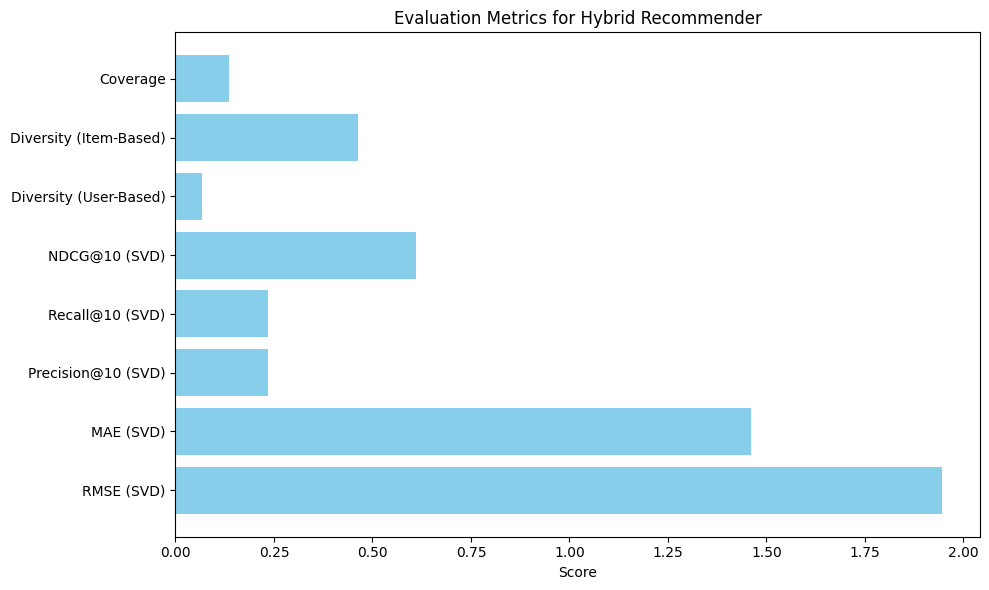

In [75]:
metrics = {
    'RMSE (SVD)': rmse,
    'MAE (SVD)': mae,
    'Precision@10 (SVD)': precision_recall_at_k(user_movie_matrix.fillna(0), pd.DataFrame(pred_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.columns))[0],
    'Recall@10 (SVD)': precision_recall_at_k(user_movie_matrix.fillna(0), pd.DataFrame(pred_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.columns))[1],
    'NDCG@10 (SVD)': ndcg_at_k(user_movie_matrix.fillna(0), pd.DataFrame(pred_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.columns)),
    'Diversity (User-Based)': control_div,
    'Diversity (Item-Based)': experiment_div,
    'Coverage': coverage(control_recs + experiment_recs, total_items=len(user_movie_matrix.columns))
}

plt.figure(figsize=(10,6))
plt.barh(list(metrics.keys()), list(metrics.values()), color='skyblue')
plt.xlabel("Score")
plt.title("Evaluation Metrics for Hybrid Recommender")
plt.tight_layout()
plt.show()